In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report

sys.path.append('../..')

from seismicpro.batchflow import Pipeline, Dataset, B, V
from seismicpro.batchflow.models.torch import VGG7
from seismicpro.src import TraceIndex
from seismicpro.src.seismic_batch_2 import (SeismicBatch,
                                            seismic_plot)
from inverse_batch import InverseBatch, predict, crop_trace
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
path_raw = '/notebooks/egor/FB/Pal/Pal_Flatiron_1k.sgy'
trace_index = TraceIndex(name='raw', path=path_raw, extra_headers=['offset'])

In [3]:
from seismicpro.batchflow import action, inbatch_parallel

class InverseBatch(SeismicBatch):
    @action
    @inbatch_parallel(init='_init_component')
    def inv_traces(self, index, src, dst, p=.5):
        pos = self.get_pos(None, src, index)
        trace = getattr(self, src)[pos]
        if np.random.choice([0, 1], p=(1-p, p)):
            getattr(self, dst[0])[pos] = (-1) * trace
            getattr(self, dst[1])[pos] = 1
        else:
            getattr(self, dst[0])[pos] = trace
            getattr(self, dst[1])[pos] = 0

    @action
    def preprocess_component(self, src, dst):
        """Prepeare data for loading into torch models."""
        data = getattr(self, src)
        data_dst = np.stack(data).astype(np.float32)
        setattr(self, dst, data_dst)
        return self
    
    @action
    def preprocess_answers(self, src, dst):
        data = getattr(self, src)
        data_res = data
        setattr(self, dst, data_res.astype(np.int32))
        return self

    @action
    def normalize_traces(self, src, dst, drop_nan=None):
        data = getattr(self, src)
        shape = np.stack(data).shape
        data = np.vstack(data)
        dst_data = (data - np.mean(data, axis=1)[:, np.newaxis]) / \
                    np.std(data, axis=1)[:, np.newaxis]
        if drop_nan is not None:
            mask = np.argwhere(np.sum(np.isnan(dst_data), axis=1) > 0).flatten()
            for i in range(len(mask)):
                dst_data[mask[i]] = dst_data[mask[i] - (-1) ** i]
        dst_data = dst_data.reshape(shape)
        setattr(self, dst, np.array([i for i in dst_data] + [None])[:-1])
        return self

In [33]:
train_subset = range(0, 60000)
train_index = trace_index.create_subset(trace_index.indices[train_subset])
train_data = Dataset(TraceIndex((train_index)), InverseBatch)

test_index = TraceIndex(trace_index.create_subset(trace_index.indices[70000:80000]))
test_data = Dataset(test_index, InverseBatch)

In [5]:
prep_ppl = (Pipeline()
          .load(components='raw', fmt='segy')
          .inv_traces(src='raw', dst=['raw', 'labels'])
          .preprocess_component(src='raw', dst='raw')
          .preprocess_answers(src='labels', dst='labels')
)

In [6]:
inputs_config = {
    'raw': {'shape': (1, 751)}, 
    'masks': {'shape': (),
              'classes': 2,
              'data_format': 'f',
              'name': 'targets'}
    }

config = {
    'loss': 'ce',
    'inputs': inputs_config,
    'initial_block/inputs': 'raw',
    'optimizer': ('Adam', {'lr': 0.001}),
    'head': dict(num_classes=2),
   'device': 'cuda',
}

In [7]:
train_ppl = prep_ppl + (Pipeline()
             .init_model('dynamic', VGG7, 'model', config)
             .init_variable('loss', init_on_each_run=list)
             .train_model('model', B('raw'), B('labels'),  
                          fetches='loss', save_to=V('loss', mode='a'))
)

In [8]:
ppl = (train_ppl << train_data)

In [9]:
ppl.run(400, n_epochs=20, shuffle=True, drop_last=True, bar=True)

100%|█████████▉| 2999/3000 [22:11<00:00,  2.30it/s]


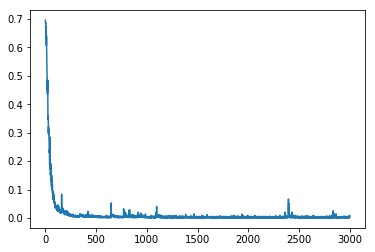

In [10]:
plt.plot(ppl.get_variable('loss'))

In [ ]:
m = ppl.get_model_by_name('model').model

In [ ]:
b = (prep_ppl << train_data).next_batch(400, shuffle=True)

In [ ]:
import torch
sigm = torch.nn.Sigmoid()
inp = torch.Tensor(b.raw).to('cuda')
out = sigm(m(inp))

In [ ]:
pred = np.array(out.cpu().detach().numpy()[:, 1]>.5, dtype=np.int32)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
target = b.labels

In [ ]:
print(classification_report(target, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       204
           1       1.00      1.00      1.00       196

   micro avg       1.00      1.00      1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



In [34]:
pred_ppl = (Pipeline()
          .load(components='raw', fmt='segy')
          .inv_traces(src='raw', dst=['raw', 'labels'], p=0.0001)
          .import_model('model', ppl, 'model')
          .preprocess_component(src='raw', dst='raw')
          .preprocess_answers(src='labels', dst='labels')
          .init_variable('pred', init_on_each_run=list())
          .init_variable('labels', init_on_each_run=list())
          .update_variable('labels', B('labels'), mode='a') 
          .predict_model('model', B('raw'),
                         fetches='predictions',  save_to=V('pred', mode='a'))
) << test_data

In [35]:
batch = pred_ppl.run(400, drop_last=True, shuffle=True, bar=True, n_epochs=1)

 96%|█████████▌| 24/25 [00:08<00:00,  2.85it/s]


In [36]:
preds = np.array(np.concatenate(pred_ppl.get_variable('pred'))[:, 1] > .5, dtype=int)
labels = np.concatenate(pred_ppl.get_variable('labels'))

In [37]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9998
           1       1.00      1.00      1.00         2

   micro avg       1.00      1.00      1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [38]:
print('Accuracy score: {:.3}'.format(accuracy_score(labels, preds)))
print('Number of inverse traces: {}'.format(sum(labels)))
print('Number of predict inverse traces: {}'.format(sum(preds)))
false_neg = sum(labels[np.where(labels != preds)])
print('Number of missed inverse traces: {}'.format(false_neg))

Accuracy score: 1.0
Number of inverse traces: 2
Number of predict inverse traces: 2
Number of missed inverse traces: 0
